In [1]:
import numpy as np
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
from IPython import display
from torch import nn
import torch.nn.functional as F
import torchvision

In [2]:
train_dataset = torchvision.datasets.MNIST('../data/', train=True, download=True, transform=torchvision.transforms.ToTensor())

In [3]:
batch_size = 32
data_loader_train = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
class Krxk_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 512), nn.Tanh())
        self.CalculateAvg = nn.Sequential(nn.Linear(512, 2))
        self.CalculateVar = nn.Sequential(nn.Linear(512, 2))
        self.GenZParameter = self.ZParameter
        self.decoder = nn.Sequential(nn.Linear(2, 512), nn.ReLU(), nn.Linear(512, 784), nn.Sigmoid())
        def init_weight(m):
            if type(m) == nn.Linear:
                nn.init.normal_(m.weight, std=0.01)
                
        self.encoder.apply(init_weight)
        self.CalculateAvg.apply(init_weight)
        self.CalculateVar.apply(init_weight)
        self.decoder.apply(init_weight)
        
    def encode(self, X):
        return self.encoder(X)
        
    def ZParameter(self, mu, var): # 生成 隐变量 Z (正态分布映射)
        std = torch.exp(var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, Z):
        return self.decoder(Z)
    
    def forward(self, X):
        encodings = self.encode(X)
        mu = self.CalculateAvg(encodings)
        std = self.CalculateVar(encodings)
        z = self.GenZParameter(mu, std)
        return self.decode(z), mu, std

In [5]:
def loss(y, y_hat, mu, std):
    reconst_loss = F.mse_loss(y, y_hat,reduction='sum') / batch_size
    kl_loss = torch.sum(-0.5 * torch.sum(1 + std - mu**2 - torch.exp(std), 1), 0) / batch_size
    return reconst_loss, kl_loss

In [ ]:
model = Krxk_model()

In [17]:
lr = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [7]:
# 模型测试
# X = torch.randn(32, 1, 28, 28)
# for layer in model.net:
#     X=layer(X)
#     print(layer.__class__.__name__,'output shape:\t',X.shape)

In [8]:
# 输入输出测试
# print(model.net)
for X, _ in data_loader_train:
#         print(X.shape, y.shape)
        y = torch.flatten(X, start_dim = 1)
        print(X.shape)
        y_hat = model.forward(X)
        res = y_hat
        print(y.shape)
        
        break

torch.Size([32, 1, 28, 28])
torch.Size([32, 784])


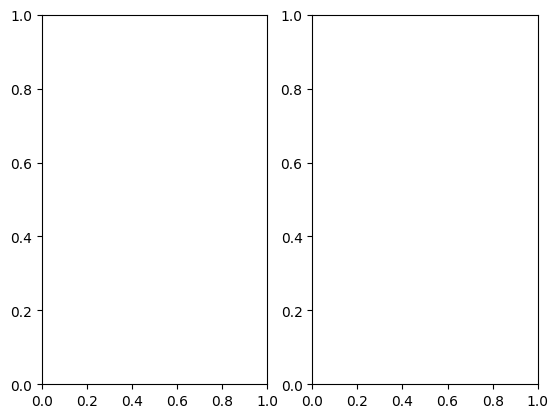

In [18]:
# 初始化绘图环境
fig, axes = plt.subplots(1, 2)

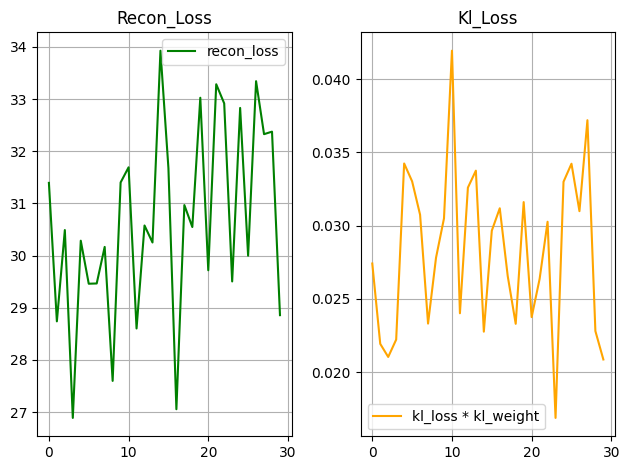

Epoch 29 Recon_Loss: 28.858877182006836
Epoch 29 Kl_Loss * kKl_Weight: 0.020856080576777458
Finished


In [19]:
%time
epochs = 30
device = 'cuda' if torch.cuda.device_count()>0 else 'cpu'
kl_weight = 0.00025

epoch_loss = []
accuracy = []

print('训练设备：', device)

model.to(device)
for epoch in range(epochs):
    pre_true = 0
    pre_total = 0
    for X, _ in data_loader_train:
        y = torch.flatten(X, start_dim = 1)
        X, y = X.to(device), y.to(device)
        y_hat, mu, std = model.forward(X)
        
        # 计算重构损失        
        recon_lost, kl_loss = loss(y, y_hat, mu, std)
        l = (recon_lost + kl_loss * kl_weight)/batch_size
#         print(l)
        optimizer.zero_grad()
        l.mean().backward()
        optimizer.step()
    
    epoch_loss.append(recon_lost.cpu().detach().numpy())
    accuracy.append((kl_loss * kl_weight).cpu().detach().numpy())
    
    for ax in axes:
        ax.cla() # 清空绘图缓存
        
    axes[0].plot(range(epoch+1), epoch_loss, 'green',label='recon_loss')
    axes[1].plot(range(epoch+1), accuracy, 'orange',label='kl_loss * kl_weight')
    display.clear_output(wait=True) # 清空上一步输出

    axes[0].set_title('Recon_Loss')
    axes[1].set_title('Kl_Loss')
    for ax in axes:
        ax.grid()
        ax.legend()

    fig.tight_layout()
    display.display(fig)
    
    print(f'Epoch {epoch} Recon_Loss: {recon_lost}')
    print(f'Epoch {epoch} Kl_Loss * kKl_Weight: {kl_loss * kl_weight}')

print('Finished')

In [20]:
# 保存
torch.save(model.state_dict(), './hw_3-MINIST(VAE).bin')

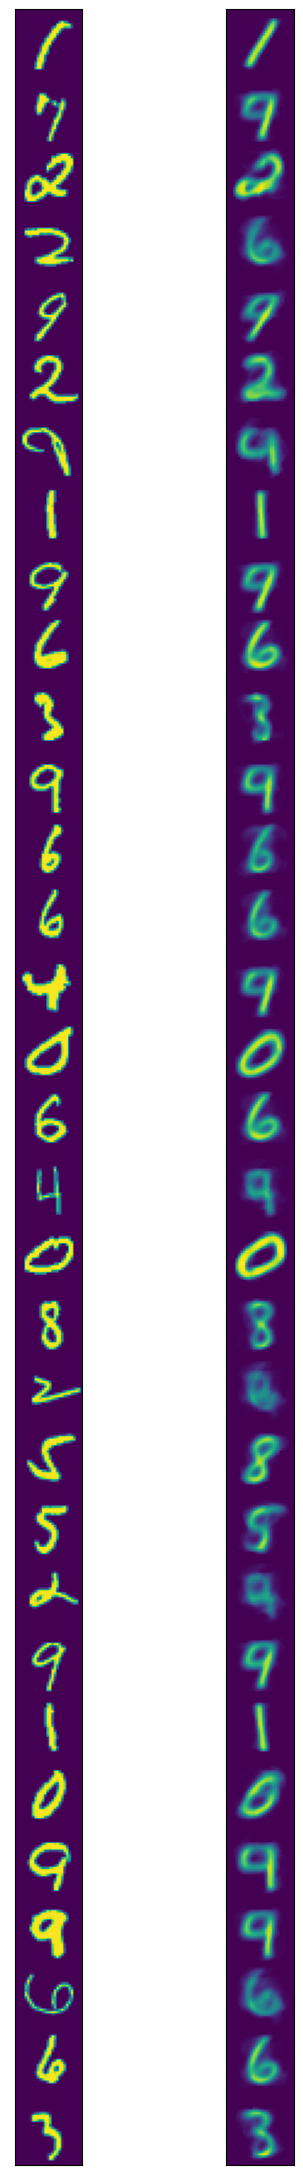

In [21]:
# 生成重构图片
fig, axes = plt.subplots(1, 2, figsize=(5,28))
model.eval()
for X, label in data_loader_train:
    y = torch.flatten(X, start_dim = 1)
    X, y = X.to(device), y.to(device)
    y_hat, _ , _ = model.forward(X) # 重构输出
    
    old = torch.flatten(torch.unflatten(y, 1, (28, 28)), 0, 1).cpu().detach().numpy()
    out = torch.flatten(torch.unflatten(y_hat, 1, (28, 28)), 0, 1).cpu().detach().numpy()

    axes[0].imshow(old)
    axes[1].imshow(out)
    
    plt.imsave('Original.png',old)
    plt.imsave('Reconstruct.png', out)
    break

for i in range(2):
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
# plt.tight_layout()
    

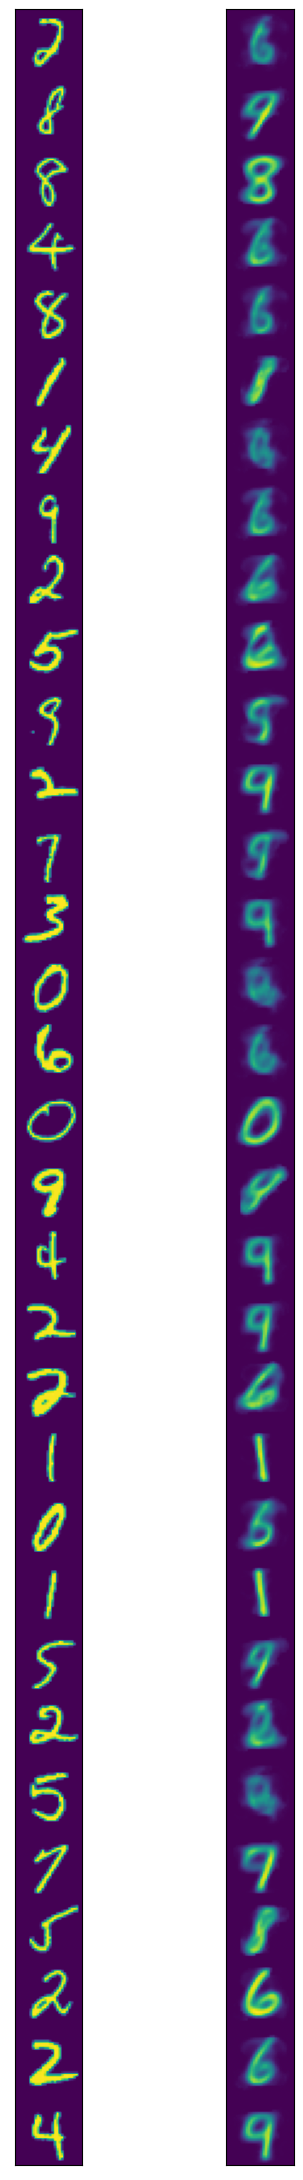

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(5,28))

temp_z = torch.zeros((batch_size, 2), device=device)
count = 0

for X, label in data_loader_train:
    y = torch.flatten(X, start_dim = 1)
    X, y = X.to(device), y.to(device)
    e = model.encode(y)
    mu = model.CalculateAvg(e)
    std = model.CalculateVar(e)
    z = model.GenZParameter(mu, std)
    temp_z += z  # 重构输出
    count += 1
    if count >= 2:
        break

model.eval()
temp_z /= 2
y_hat = model.decode(temp_z)

old = torch.flatten(torch.unflatten(y, 1, (28, 28)), 0, 1).cpu().detach().numpy()
out = torch.flatten(torch.unflatten(y_hat, 1, (28, 28)), 0, 1).cpu().detach().numpy()

axes[0].imshow(old)
axes[1].imshow(out)
    
# plt.imsave('Original.png',old)
plt.imsave('Generate.png', out)

for i in range(2):
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)